In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import random
import time
from tqdm import tqdm
from matplotlib import pyplot as plt
from pprint import pprint

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# fix random number generation aka regenerate the same random numbers every time (such as weight and bias initialization )
def set_random_seed(seed=7, deterministic=True):
    """Set random seed, for python, numpy, pytorch

    Args:
        seed (int): Seed to be used.
        deterministic (bool): Whether to set the deterministic option for
            CUDNN backend, i.e., set `torch.backends.cudnn.deterministic`
            to True and `torch.backends.cudnn.benchmark` to False.
            Default: True.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False 
seed=7        
set_random_seed(seed=seed)

In [3]:
df = pd.read_csv("../data/data.csv")
df.head(7)

,weekday_name,month,leap_year_condition,decade,output,output_year_digit,output_year,valid_years_list,valid_day_list,decade4,decade100,decade400,valid_group_days_index
0,2,1,0,180,1-1-1800,0,1800,"[0, 1, 2, 3, 5, 6, 7, 9]","[1, 8, 15, 22, 29]",0,0,1,7
1,3,1,0,180,1-1-1801,1,1801,"[0, 1, 2, 3, 5, 6, 7, 9]","[1, 8, 15, 22, 29]",0,0,1,7
2,4,1,0,180,1-1-1802,2,1802,"[0, 1, 2, 3, 5, 6, 7, 9]","[1, 8, 15, 22, 29]",0,0,1,7
3,5,1,0,180,1-1-1803,3,1803,"[0, 1, 2, 3, 5, 6, 7, 9]","[1, 8, 15, 22, 29]",0,0,1,7
4,6,1,1,180,1-1-1804,4,1804,"[4, 8, 4, 4, 4, 4, 4, 4]","[1, 8, 15, 22, 29]",0,0,1,7
5,1,1,0,180,1-1-1805,5,1805,"[0, 1, 2, 3, 5, 6, 7, 9]","[1, 8, 15, 22, 29]",0,0,1,7
6,2,1,0,180,1-1-1806,6,1806,"[0, 1, 2, 3, 5, 6, 7, 9]","[1, 8, 15, 22, 29]",0,0,1,7


- given the columns features we can't by any means diffrentiate between the day 1 or day 8 or 15 or 22 or 28 because they may share the same exact feature columns values and they all still correct, and the model see them all as the same thing, so i make lists for the identical days from the feature columns point of view, and instead of training the model to select certain day, i trained the model to select index of days-list which i named "groups", as example if the output of the model is 0 then it equivalent to selecting any day from these days [1, 8, 15, 22], if the output is 1 so it's equivalent to selecting any number from [2, 9, 16, 23] and so on(see groups_dict dictionary)

In [4]:
# list of all possibole (10) output lists, the output must be one of theses lists
groups = [[1, 8, 15, 22], 
         [2, 9, 16, 23], 
         [3, 10, 17, 24], 
         [4, 11, 18, 25], 
         [5, 12, 19, 26], 
         [6, 13, 20, 27], 
         [7, 14, 21, 28],
         [1, 8, 15, 22, 29], 
         [2, 9, 16, 23, 30], 
         [3, 10, 17, 24, 31]]
groups_dict = dict(enumerate(groups))
groups_dict

{0: [1, 8, 15, 22],
 1: [2, 9, 16, 23],
 2: [3, 10, 17, 24],
 3: [4, 11, 18, 25],
 4: [5, 12, 19, 26],
 5: [6, 13, 20, 27],
 6: [7, 14, 21, 28],
 7: [1, 8, 15, 22, 29],
 8: [2, 9, 16, 23, 30],
 9: [3, 10, 17, 24, 31]}

In [5]:
x_day = df[["weekday_name", "month", "output_year", "leap_year_condition", "valid_group_days_index"]]
y_day = x_day.pop("valid_group_days_index") # from 0 to 9

**B- training for getting the day**

7    22540
8    22055
3    19248
4    19248
5    19248
6    19248
9    14035
2     8020
1     1604
0     1216
Name: valid_group_days_index, dtype: int64


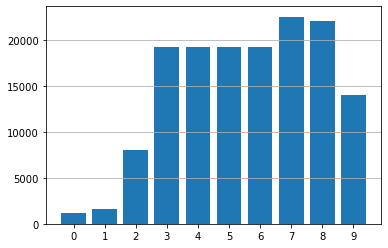

In [6]:
pprint(df.valid_group_days_index.value_counts())
plt.bar(df.valid_group_days_index.value_counts().index, df.valid_group_days_index.value_counts())
plt.xticks(range(10))
plt.grid(axis="y")
plt.show()

**the output column is imbalanced**

In [7]:
# splitting the data
xtrain_day, xtest_day, ytrain_day, ytest_day = train_test_split(x_day, y_day, 
                                                                test_size=0.19, 
                                                                shuffle=True, 
                                                                random_state=seed, 
                                                                stratify=df.valid_group_days_index)

# make oversampling to fix the imbalanced classes
ros = RandomOverSampler(random_state=7)
x_day_train_sampld, y_day_train_sampld = ros.fit_resample(xtrain_day, ytrain_day)

In [8]:
class CollectedData(Dataset):
    def __init__(self, x, y):
        self.data = torch.tensor(x.values.astype(np.float32))
        self.label = torch.tensor(y.values)
        self.n_smpl = x.shape[0]
        
        
    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]
    
    def __len__(self):
        return self.n_smpl    
    
train_set_day = CollectedData(x_day_train_sampld, y_day_train_sampld)
test_set_day = CollectedData(xtest_day, ytest_day)    

In [9]:
## random_split() isn't suitable here, so that i used train_test_split function
# # train_set, test_set = torch.utils.data.random_split(dataset, [len(dataset)-test_len, int(len(dataset)*0.2)])

# train_labels_day = torch.tensor(ytrain_day.values.astype(np.float32)) 
# test_labels_day = torch.tensor(ytest_day.values.astype(np.float32)) 
# train_input_day = torch.tensor(xtrain_day.values.astype(np.float32)) 
# test_input_day = torch.tensor(xtest_day.values.astype(np.float32)) 

# train_set_day = TensorDataset(train_input_day, train_labels_day)
# test_set_day = TensorDataset(test_input_day, test_labels_day)


In [10]:
batch_size = 32

train_loader_day = DataLoader(dataset=train_set_day, shuffle=True, batch_size=batch_size)
test_loader_day = DataLoader(dataset=test_set_day, batch_size=batch_size) 

In [11]:
class network(nn.Module):
    def __init__(self, in_features=4, out_features=10):
        super().__init__()
        self.fc1 = nn.Linear(in_features, 168)
        self.fc2 = nn.Linear(168, 401)
        # self.fc3 = nn.Linear(401, 24)
        # self.fc4 = nn.Linear(20, 20)
        # self.fc5 = nn.Linear(20, 20)
        self.fc6 = nn.Linear(401, out_features) 
        self.initialize_weights()
        
        
    def forward(self, inpt):
        out = F.leaky_relu(self.fc1(inpt))
        out = F.relu(self.fc2(out))
        # out = F.leaky_relu(self.fc3(out))
        # out = F.leaky_relu(self.fc4(out))
        # out = F.leaky_relu(self.fc5(out))
        out = F.softmax((self.fc6(out)), dim=1)
        return out
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

In [12]:
# calculating accuracy
@torch.no_grad()
def calculate_accuracy(model, data_loader=train_loader_day):
    model.eval()
    
    num_correct, num_samples = 0, 0

    for data, labels in data_loader:
        
        # transfering data to cuda
        data = data.to(device=device)
        labels = labels.to(device=device)
                
        preds = model(data)
        num_correct += sum(list(preds.argmax(dim=1)==labels))
        num_samples += len(labels)
    accuracy = num_correct/num_samples
    model.train()
    return accuracy  

In [13]:
# initializing the model
model = network(in_features=4, out_features=10).to(device)
lr = 0.001
# loss and optimizer initializing
criterion = nn.CrossEntropyLoss()
# criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=35, verbose=True)
model

network(
  (fc1): Linear(in_features=4, out_features=168, bias=True)
  (fc2): Linear(in_features=168, out_features=401, bias=True)
  (fc6): Linear(in_features=401, out_features=10, bias=True)
)

In [ ]:
num_epochs = 33
def train_model(num_epochs, data_loader=train_loader_day):
    num_batches = len(data_loader)
    print(f"starting learning rate = {lr} \n number of epochs = {num_epochs} \n number of batches = {num_batches} \n")
    # starting training loop epochs
    result_train_acc, result_test_acc = [], []
    for epoch in range(num_epochs):
        start_time = time.time()
        progress = tqdm(enumerate(data_loader), total=num_batches, leave=True)
        for batch_idx, (data, labels) in progress: 

            # convert data to device
            data = data.to(device=device)
            labels = labels.to(device=device)

            # getting prediction and loss
            preds = model(data)
            loss = criterion(preds, labels)

            # back propagation
            optimizer.zero_grad()
            loss.backward()

            # optimization step
            optimizer.step()

            progress.set_description(f"epoch [{1+epoch}/{num_epochs}], loss={loss.item():0.4f}")
            progress.set_postfix()

        train_acc = calculate_accuracy(model, data_loader=train_loader_day)
        test_acc = calculate_accuracy(model, data_loader=test_loader_day)
        schedular.step(test_acc)
        print(f"after {1+epoch} epoch, train_acc = {(train_acc*100):.2f}%, test_acc = {(test_acc*100):.2f}%, time_elapsed = {((time.time()-start_time)/60):.1f} minuts")
        result_train_acc += [train_acc]
        result_test_acc += [test_acc]
    return result_train_acc, result_test_acc
result_train_acc, result_test_acc = train_model(num_epochs, data_loader=train_loader_day)


In [ ]:
plt.plot(list(range(num_epochs)), result_train_acc)
plt.title("train accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy percentage")
plt.show()

In [ ]:
plt.plot(list(range(num_epochs)), result_test_acc)
plt.title("test accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy percentage")
plt.show()

In [17]:
d_test = xtest_day
dt = d_test.copy(deep=True)
d_test = torch.tensor(d_test.values.astype(np.float32))
preds = model(d_test.to(device=device)).argmax(dim=1).cpu()
dt["predicted_days_group_index"] = preds
dt["out"] = ytest_day
dt

C:\Users\huzyfa\AppData\Local\Temp/ipykernel_13216/3722298390.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax((self.fc6(out)))


,weekday_name,month,output_year,leap_year_condition,predicted_days_group_index,out
19729,3,2,1880,1,4,4
18483,5,11,1837,0,4,3
103614,6,7,1956,1,4,7
8841,1,11,1819,0,4,8
97054,5,3,1812,1,4,6
...,...,...,...,...,...,...
22506,3,9,1850,0,4,4
10317,6,2,2092,1,4,2
5001,0,1,1989,0,4,8
113721,1,8,2038,0,4,9


In [18]:
dt["predicted_days_group_index"].unique()

array([4], dtype=int64)

In [42]:
days_tensor = torch.tensor(d_test[["weekday_name", "month", "output_year", "leap_year_condition"]].values.astype(np.float32))
preds = model(days_tensor.to(device=device))


In [ ]:
torch.save(model, "../data/day_model_saved")
model = torch.load("../data/day_model_saved")

In [ ]:
dt.to_csv("../data/day_predections.csv", header=True, index=True)